In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from saif.crs_model.peakdetector import pk_indxs
import saif.scinet.model as scinet
plt.style.use('ggplot')

%matplotlib inline

In [2]:
# from saif.scinet.dataset import daily_seismic_and_interpolated_pressure
# from saif.scinet.dataset import construct_time_series_dataset

from dataset import daily_seismic_and_interpolated_pressure
from dataset import construct_time_series_dataset
from dataset import overlap_and_interpolate
from dataset import aggregate_seismic

from torch.utils.data import DataLoader

In [3]:
import pandas as pd
# seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
# pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

seismic_original = pd.read_csv("seismic.csv",index_col=0)
pressure_original = pd.read_csv("pressure.csv",index_col=0)

# seismic = seismic.drop(columns=['kmeans'])

seismic = pd.read_csv("temporal_datasets_decatur_illinois_seismic_new.csv",index_col=None)
pressure = pd.read_csv("temporal_datasets_decatur_illinois_pressure_new.csv",index_col=None)

pressure["epoch"] = pressure["epoch"]



In [53]:
input_len = 16 # try wider window power of 2
horizon = 7 # prediction window

In [54]:
features_original, target_vals_original = daily_seismic_and_interpolated_pressure(seismic_original, pressure_original)


In [55]:
features, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)


In [56]:
import math

import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset

from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

seismic_start = seismic.epoch.values[0]
seismic_end = seismic.epoch.values[-1]
    
pressure_start = pressure.epoch.values[0]
pressure_end = pressure.epoch.values[-1]
t0 = max(seismic_start, pressure_start)
t1 = min(seismic_end, pressure_end)

Visualization of the train / test split

Text(0, 0.5, 'normalized cumulative counts')

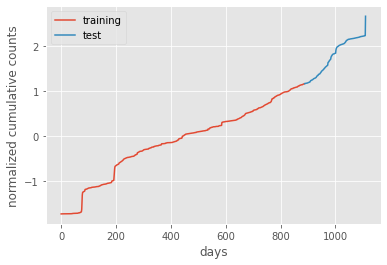

In [57]:
train_dset, test_dset, x_scaler, y_scaler = construct_time_series_dataset(
    features, target_vals, 
    input_len, horizon, features.columns, 
    train_test_split=0.8, normalize_data=True
)

plt.figure()
plt.plot(np.arange(len(train_dset.Y)), train_dset.Y, label='training')
plt.plot(np.arange(len(test_dset.Y)) + len(train_dset.Y), test_dset.Y, label='test')
plt.legend()
plt.xlabel('days')
plt.ylabel('normalized cumulative counts')

In [52]:
len(train_dset.X) 

888

### Model Architecture

In [58]:
class SimpleSCINet(nn.Module):
    def __init__(
        self, 
        input_len, output_len,
        input_dim, num_levels, kernel_size, dropout, groups, hidden_size
    ):
        super().__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_levels = num_levels
        self.groups = groups
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm1d(self.input_dim)
        self.bn2 = nn.BatchNorm1d(self.input_dim)
        
        self.block1 = scinet.EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=True
        )
        
        # I'm a bit iffy on using a projector like this across features
        # But this is what they do in scinet
        # It should be fine, kernel size is 1, it's essentially just an
        # aggregation operation
        self.time_projector = nn.Conv1d(
            self.input_len, self.output_len,
            kernel_size=1, stride=1, bias=False
        )
        
        self.channel_projector = nn.Conv1d(
            self.input_dim, 1, kernel_size=1, stride=1, bias=True
        )
    
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.bn1(out)
        out = out.permute(0, 2, 1)
        
        out = self.block1(out)
        out += out
        
        out = F.relu(out)
        out = self.time_projector(out)
        
        out = out.permute(0, 2, 1)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.channel_projector(out).squeeze(1)
        
        #Enforcing monotonicity
        #out = torch.exp(out)
        #out = F.relu(out)
        # Exp has numerical issues, and relu was collapsing.
        # Squaring is also a positive operation
        out = out ** 2
        #out = torch.sigmoid(out)
        out = out.cumsum(-1) + x[:, -1, -1, None]
        
        return out

### Hyperparameters

In [59]:
input_dim = train_dset.X.shape[1]
num_levels = 2 # number of levels in the scinet tree
kernel_size = 4 # kernel size for the conv1D operations
dropout = 0.5 # dropout regularization params
groups = 1 # number of groups in the conv1D operation
hidden_size = 3 # scaling factor for the hidden dimension

lr = 1e-3 # learning rate
n_epoch = 64 # number of epochs

# Choose your loss function!
# criterion = nn.MSELoss() # L2 loss
criterion = nn.HuberLoss() #An alternative, smoother version of the L1 Loss
# Less sensitive to outliers, less prone to exploding gradients

### Run Training

In [60]:

from tqdm.notebook import tqdm

In [61]:
torch.manual_seed(0) # Use different seeds for 10 times

train_loader = DataLoader(
    train_dset,
    batch_size=32,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_dset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)

model = SimpleSCINet(
    input_len, horizon,
    input_dim, num_levels, kernel_size, 
    dropout, groups, hidden_size
)

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_vals = []
test_loss_vals = []


for epoch in tqdm(range(n_epoch)):
    #train loop
    model.train()
    batch_loss_vals = []
    for (batch_x, batch_y) in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        batch_loss_vals.append(loss.item())
    train_loss_vals.append(np.mean(batch_loss_vals))
    
    #eval loop
    model.eval()
    batch_loss_vals = []
    for (batch_x, batch_y) in test_loader:        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        batch_loss_vals.append(loss.item())
    test_loss_vals.append(np.mean(batch_loss_vals))

  0%|          | 0/64 [00:00<?, ?it/s]

In [62]:
# print Huber Loss
test_loss_vals

[0.2779181588973318,
 0.05305259195821626,
 0.03640718186008079,
 0.0302949831155794,
 0.023994563413517817,
 0.0178794851526618,
 0.013251858397520013,
 0.010073602099769883,
 0.009160397175167288,
 0.008169720232087587,
 0.01055761709410165,
 0.012038930751649397,
 0.006633167678955942,
 0.006650202300599111,
 0.005126473152943488,
 0.0066444798721931875,
 0.004792513084664408,
 0.005172055900662339,
 0.0029976593546702395,
 0.004577724404433476,
 0.00464431566901372,
 0.0028137732879258692,
 0.0023938174708746374,
 0.0029324159217399676,
 0.0017876467526158585,
 0.0027736682365814757,
 0.0022721258407857802,
 0.0023037820771735695,
 0.0022820558910357897,
 0.0018322065651383518,
 0.0019527929731079244,
 0.001907320348046986,
 0.0018187635370330618,
 0.0012004421608123397,
 0.0011602469042242905,
 0.0018980980904806139,
 0.0011566976796270215,
 0.001388113243072959,
 0.0022460364936185734,
 0.0016787161959135638,
 0.0012737762735923752,
 0.0011861702992713877,
 0.0013695297654651637,

Text(0.5, 0, 'Epoch')

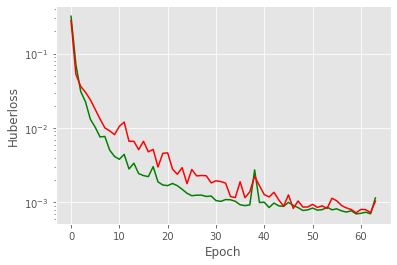

In [63]:
plt.plot(train_loss_vals, color='g', label='train')
plt.plot(test_loss_vals, color='r', label='test')
plt.ylabel('Huberloss')
# plt.ylim([0,2])
plt.yscale('log')
plt.xlabel('Epoch')

Visualize the forecast

In [37]:
start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon

sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]


In [38]:
def monte_carlo_sample(model, x, n_samples=50, seed=0):
    torch.manual_seed(seed)
    model.train()
    
    # We want the model to be in training mode
    # Except for the BN.
    # There is potentially a more elegant way to do this
    # Ex by making a different "mode" in our own model groups
    model.bn1.training = False
    model.bn2.training = False
    
    samples = []
    for _ in range(n_samples):
        samples.append(model(x).data)
    samples = torch.stack(samples)
    
    model.eval()
    return samples.permute(1, 0, 2)

In [39]:
model.eval()
pred_y = model(sample_x[None, :, :]).squeeze(0).data

In [40]:
samples = monte_carlo_sample(model, sample_x[None, :, :], n_samples=10)
samples = samples.squeeze(0).data.numpy()

In [41]:
sample_mean = samples.mean(0)
sample_std = samples.std(0)

## You can use mean +/- std, or percentile, to visualize the distribtion

# Uncomment to use mean +/- std
#sample_ub = sample_mean + sample_std
#sample_lb = sample_mean - sample_std

# Use percentiles
sample_ub = np.percentile(samples, 90, axis=0)
sample_lb = np.percentile(samples, 10, axis=0)

sample_max = samples.max(0)
sample_min = samples.min(0)

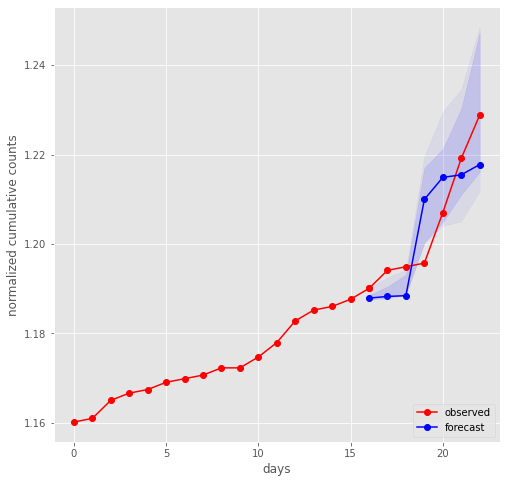

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(np.arange(start_input, end_input+1), input_y, 'r', marker='o', label='observed')
ax.plot(np.arange(end_input, end_output), output_y, 'r', marker='o')
ax.fill_between(np.arange(end_input, end_output), sample_ub, sample_lb, alpha=0.1, color='b')
ax.fill_between(np.arange(end_input, end_output), sample_max, sample_min, alpha=0.05, color='b')
ax.plot(np.arange(end_input, end_output), pred_y, 'b', marker='o', label='forecast')

plt.xlabel('days')
plt.ylabel('normalized cumulative counts')
plt.legend(loc='lower right')
plt.show()

In [ ]:
criterion = nn.MSELoss() # L2 loss


## Trying out new prediction routine 

In [145]:
model.train()
model.bn1.training=False
model.bn2.training=False

start_input = 0
end_input = start_input + input_len
end_output = end_input + horizon



In [146]:
sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]
input_y


tensor([1.1602, 1.1610, 1.1651, 1.1667, 1.1675, 1.1691, 1.1699, 1.1707, 1.1723,
        1.1723, 1.1747, 1.1780, 1.1828, 1.1852, 1.1860, 1.1877, 1.1901])

In [147]:
torch.cat((input_y,model(sample_x[None,:,:]).data.squeeze(0)))

tensor([1.1602, 1.1610, 1.1651, 1.1667, 1.1675, 1.1691, 1.1699, 1.1707, 1.1723,
        1.1723, 1.1747, 1.1780, 1.1828, 1.1852, 1.1860, 1.1877, 1.1901, 1.1877,
        1.1878, 1.1882, 1.2131, 1.2192, 1.2230, 1.2266])

In [148]:
model(sample_x[None,:,:])

tensor([[1.1877, 1.1887, 1.1907, 1.1947, 1.1950, 1.1996, 1.2062]],
       grad_fn=<AddBackward0>)

In [149]:
samples = []
outputs_y = []
sample_x = test_dset.X[start_input:end_input]
input_y = test_dset.Y[start_input:end_input+1]
output_y = test_dset.Y[end_input:end_output]
for i in range(2):
    outputs_y.append(output_y)
    _predict = model(sample_x[None,:,:])
    samples.append(_predict.data.squeeze())
    start_input = start_input + horizon
    end_input = end_input + horizon
    end_output = end_input + horizon
    sample_x = test_dset.X[start_input:end_input]
    input_y = torch.cat((input_y,_predict.data.squeeze(0)))
    output_y = test_dset.Y[end_input:end_output]
    model.eval()



In [150]:
torch.cat(samples).squeeze().squeeze()

tensor([1.1877, 1.1881, 1.1892, 1.2158, 1.2212, 1.2254, 1.2408, 1.2293, 1.2293,
        1.2298, 1.2416, 1.2425, 1.2505, 1.2674])

In [151]:
torch.cat(outputs_y)

tensor([1.1901, 1.1941, 1.1949, 1.1957, 1.2070, 1.2191, 1.2288, 1.2304, 1.2320,
        1.2337, 1.2409, 1.2417, 1.2450, 1.2482])

In [152]:
torch.cat(samples)

tensor([1.1877, 1.1881, 1.1892, 1.2158, 1.2212, 1.2254, 1.2408, 1.2293, 1.2293,
        1.2298, 1.2416, 1.2425, 1.2505, 1.2674])

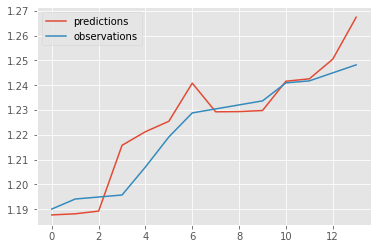

In [154]:
plt.plot(torch.cat(samples),label='predictions')
plt.plot(torch.cat(outputs_y),label='observations')
plt.legend()